In [2]:
import os
import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Define paths to extracted directories
data_dir_a = "../training_setA"
data_dir_b = "../training_setB"

# Function to load PSV (Pipe-Separated Values) files
def load_data(directory):
    dfs = []
    for file in os.listdir(directory):
        if file.endswith(".psv"):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path, sep='|')  # Read as pipe-separated values
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load datasets
df_a = load_data(data_dir_a)
df_b = load_data(data_dir_b)


In [4]:
# Combine both datasets
df = pd.concat([df_a, df_b], ignore_index=True)

# Display basic information
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 41 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   HR                1398811 non-null  float64
 1   O2Sat             1349474 non-null  float64
 2   Temp              525226 non-null   float64
 3   SBP               1325945 non-null  float64
 4   MAP               1358940 non-null  float64
 5   DBP               1065656 non-null  float64
 6   Resp              1313875 non-null  float64
 7   EtCO2             57636 non-null    float64
 8   BaseExcess        84145 non-null    float64
 9   HCO3              65028 non-null    float64
 10  FiO2              129365 non-null   float64
 11  pH                107573 non-null   float64
 12  PaCO2             86301 non-null    float64
 13  SaO2              53561 non-null    float64
 14  AST               25183 non-null    float64
 15  BUN               106568 non-null   float64
 16  

In [5]:
# Preprocessing: Handle missing values
df = df.fillna(0)

# Encoding categorical variables (if any)
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Set target variable (SepsisLabel)
X = df.drop(columns=['SepsisLabel'])  # 'SepsisLabel' is the target variable
y = df['SepsisLabel']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Subset of X_test
X_test_subset = X_test.iloc[:100]
X_test_scaled_subset = X_test_scaled[:100]

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate model
preds = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, preds)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9828


In [6]:

# SHAP Analysis
explainer = shap.TreeExplainer(model)


In [ ]:
p_values = explainer(X_test_scaleshad_subset)

<Figure size 640x480 with 0 Axes>

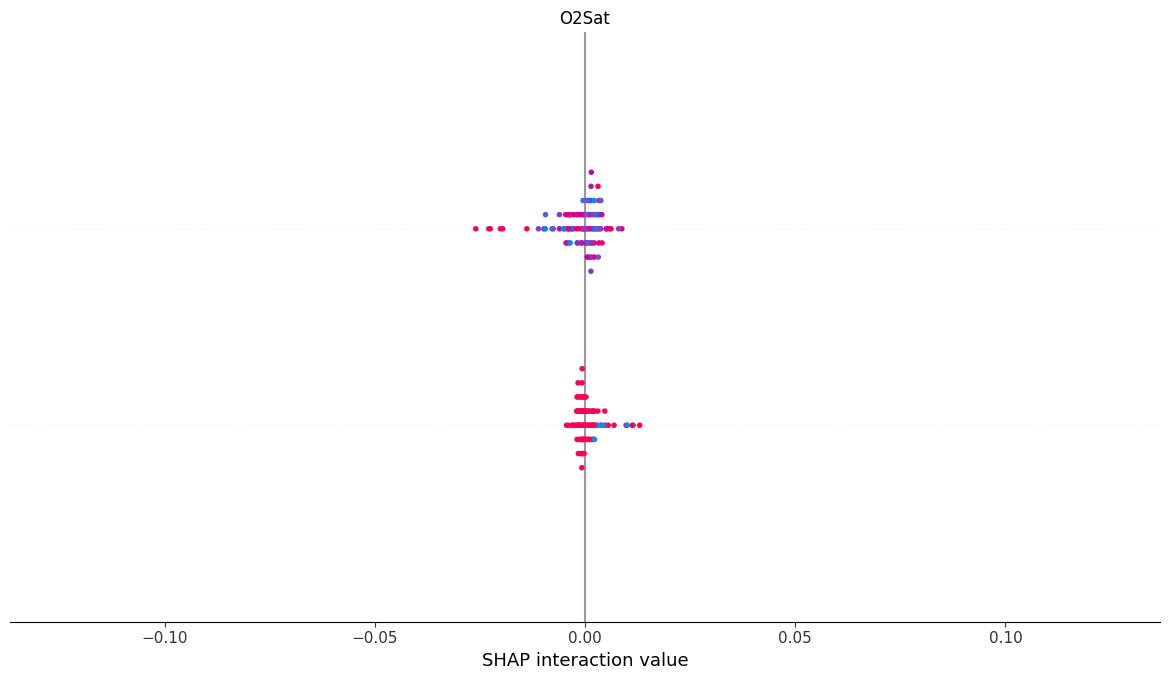

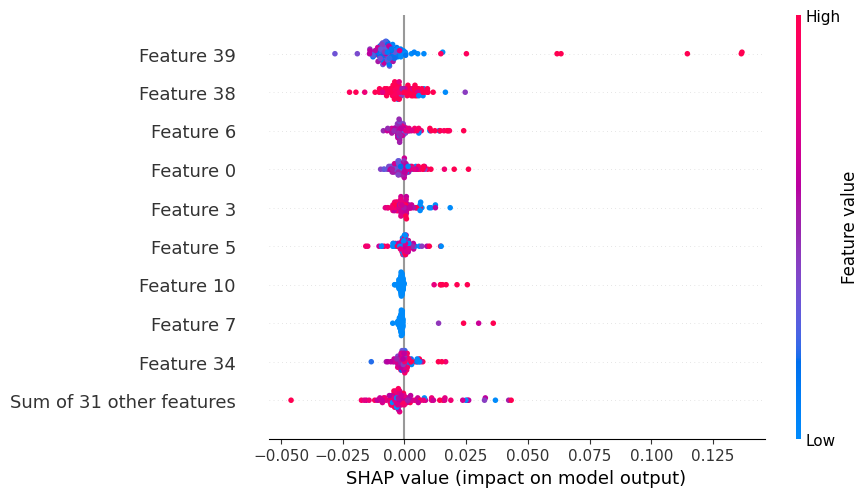

In [9]:
# Summary plot
shap.summary_plot(shap_values, X_test_subset, plot_type="bar")
shap.plots.beeswarm(shap_values[:,:,1])

In [ ]:
# LIME Analysis
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled,
                                                         feature_names=X.columns.tolist(),
                                                         class_names=['No Sepsis', 'Sepsis'],
                                                         discretize_continuous=True)

idx = 0  # Index of instance to explain
exp = lime_explainer.explain_instance(X_test_scaled[idx], model.predict_proba)
exp.show_in_notebook()

In [ ]:
# SHAP Dependence Plots for top 3 important features
top_features = np.argsort(np.abs(shap_values[1]).mean(axis=0))[-3:]
for feature in top_features:
    shap.dependence_plot(feature, shap_values[1], X_test, feature_names=X.columns)

In [ ]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
shap_importance = np.abs(shap_values[1]).mean(axis=0)
sns.barplot(x=shap_importance, y=X.columns)
plt.title("Feature Importance based on SHAP Values")
plt.show()

# Save results
df_results = pd.DataFrame({'Feature': X.columns, 'SHAP Importance': shap_importance})
df_results.to_csv("../shap_feature_importance.csv", index=False)
print("SHAP analysis saved.")